In [1]:
import ast

%matplotlib inline
import xtgeo
import resqpy
import numpy as np
import pandas as pd
from resqpy.model import Model, new_model
from resqpy.surface import Mesh
from resqpy.crs import Crs

from fmu.sumo.explorer import Explorer
sumo = Explorer("dev")

In [2]:
surface = sumo.get_surface_by_uuid("87f9423f-4d9d-9ef1-fb41-e6be452f0a17")
metadata = surface.metadata
spec = metadata['data']['spec']

metadata['data']

{'masterdata': {'smda': {'field': [{'identifier': 'DROGON',
     'uuid': '00000000-0000-0000-0000-000000000000'}]}},
 'file': {'checksum_md5': '5818fdd860b445b41c337fd9d8150384',
  'relative_path': 'realization-0/iter-0/share/results/maps/basevolantis--ds_extract_geogrid.gri'},
 'access': {'asset': {'name': 'Drogon'}},
 'data': {'tagname': 'DS_extract_geogrid',
  'is_prediction': True,
  'bbox': {'ymin': 5926551.219238281,
   'zmin': 1600.4984130859375,
   'xmin': 456063.69140625,
   'ymax': 5939431.219238281,
   'zmax': 2000.4561767578125,
   'xmax': 467483.69140625},
  'format': 'irap_binary',
  'name': 'VOLANTIS GP. Base',
  'stratigraphic': True,
  'vertical_domain': 'depth',
  'is_observation': False,
  'content': 'depth',
  'spec': {'ncol': 572,
   'yori': 5926551.219238281,
   'xori': 456063.69140625,
   'rotation': 0,
   'undef': 1e+30,
   'yinc': 20,
   'xinc': 20,
   'nrow': 645,
   'yflip': 1}},
 'fmu': {'context': {'stage': 'realization'},
  'iteration': {'name': 'iter-0'},

Instantiate new model of surface 

In [3]:
#model = Model(new_epc=True)
model = new_model(epc_file="surface.epc")

Add coordinate reference system of the surface metadata to the model

In [4]:
x_offset = spec['xori']
y_offset = spec['yori']
rotation = spec['rotation']
z_inc_down = bool(spec['yflip']) # Determines "handedness" of coordinate system https://en.wikipedia.org/wiki/Right-hand_rule#Coordinates
title = "Surface Coordinate Reference System"

crs = Crs(model, x_offset=x_offset, y_offset=y_offset, rotation=rotation, z_inc_down=z_inc_down, title=title)

Add a mesh (2d grid) of the surface data to the model

In [5]:
regsurf = xtgeo.surface_from_file(surface.blob)
regsurf.values.fill_value = spec['undef']

# Here xy(z) -> ij where i = x, j = y dirs
origin = (0,0,0)
ni = spec['nrow']
nj = spec['ncol']
dxyz_dij = np.array([[spec['xinc'], 0, 0],
                     [0, spec['yinc'], 0]])
z_values = regsurf.values
crs_uuid = crs.uuid
title = "Surface Mesh"

mesh = Mesh(model, z_values=z_values, origin=origin, ni=ni, nj=nj, dxyz_dij=dxyz_dij, crs_uuid=crs_uuid, title=title)

# Append fmu metadata dict to the mesh
extra_metadata = metadata
extra_metadata['uuid'] = surface.uuid
mesh.append_extra_metadata(extra_metadata)

Output our current surface model

In [6]:
# Write all metadata to epc file
crs.create_xml()
mesh.create_xml()
model.store_epc("surface.epc")

# Write data to hdf5 file
mesh.write_hdf5()
model.create_hdf5_ext(file_name="surface.h5")

<Element {http://www.energistics.org/energyml/data/commonv2}EpcExternalPartReference at 0x19e54e3ce40>

Try to reopen a new model from the files we just saved

In [7]:
# Recreate the model from epc file
read_model = Model("surface.epc")
read_model.parts()

['obj_LocalDepth3dCrs_1c1ed8fe-1bf5-11ee-b80e-00d49ee52a05.xml',
 'obj_Grid2dRepresentation_1c94838a-1bf5-11ee-b6cb-00d49ee52a05.xml']

In [8]:
read_model.titles()

['Surface Coordinate Reference System', 'Surface Mesh']

In [9]:
read_model.h5_file_name()

'surface.h5'

In [10]:
read_model.h5_uuid()

UUID('1c1cd94c-1bf5-11ee-be66-00d49ee52a05')

Check that stored array is intact

In [11]:
read_mesh_uuid = read_model.uuid(obj_type="obj_Grid2dRepresentation")

read_mesh = Mesh(read_model, uuid=read_mesh_uuid)
print("Shape:", read_mesh.full_array_ref().shape)
print("Sample array piece:", read_mesh.full_array_ref()[206, 41])
print("Sample array piece:", read_mesh.full_array_ref()[206, 206])

Shape: (572, 645, 3)
Sample array piece: [8.20000000e+02 4.12000000e+03 1.00000002e+30]
Sample array piece: [4120.         4120.         1724.98217773]


In [12]:
print("Shape:", mesh.full_array_ref().shape)
print("Sample array piece:", mesh.full_array_ref()[206, 41])
print("Sample array piece:", read_mesh.full_array_ref()[206, 206])

Shape: (572, 645, 3)
Sample array piece: [8.20000000e+02 4.12000000e+03 1.00000002e+30]
Sample array piece: [4120.         4120.         1724.98217773]


Check that extra metadata is intact

In [13]:
read_mesh.extra_metadata

{'masterdata': "{'smda': {'field': [{'identifier': 'DROGON', 'uuid': '00000000-0000-0000-0000-000000000000'}]}}",
 'file': "{'checksum_md5': '5818fdd860b445b41c337fd9d8150384', 'relative_path': 'realization-0/iter-0/share/results/maps/basevolantis--ds_extract_geogrid.gri'}",
 'access': "{'asset': {'name': 'Drogon'}}",
 'data': "{'tagname': 'DS_extract_geogrid', 'is_prediction': True, 'bbox': {'ymin': 5926551.219238281, 'zmin': 1600.4984130859375, 'xmin': 456063.69140625, 'ymax': 5939431.219238281, 'zmax': 2000.4561767578125, 'xmax': 467483.69140625}, 'format': 'irap_binary', 'name': 'VOLANTIS GP. Base', 'stratigraphic': True, 'vertical_domain': 'depth', 'is_observation': False, 'content': 'depth', 'spec': {'ncol': 572, 'yori': 5926551.219238281, 'xori': 456063.69140625, 'rotation': 0, 'undef': 1e+30, 'yinc': 20, 'xinc': 20, 'nrow': 645, 'yflip': 1}}",
 'fmu': "{'context': {'stage': 'realization'}, 'iteration': {'name': 'iter-0'}, 'case': {'name': 'rowh_kmd_bleed_fri01', 'user': {'id': 

In [14]:
mesh.extra_metadata

{'masterdata': "{'smda': {'field': [{'identifier': 'DROGON', 'uuid': '00000000-0000-0000-0000-000000000000'}]}}",
 'file': "{'checksum_md5': '5818fdd860b445b41c337fd9d8150384', 'relative_path': 'realization-0/iter-0/share/results/maps/basevolantis--ds_extract_geogrid.gri'}",
 'access': "{'asset': {'name': 'Drogon'}}",
 'data': "{'tagname': 'DS_extract_geogrid', 'is_prediction': True, 'bbox': {'ymin': 5926551.219238281, 'zmin': 1600.4984130859375, 'xmin': 456063.69140625, 'ymax': 5939431.219238281, 'zmax': 2000.4561767578125, 'xmax': 467483.69140625}, 'format': 'irap_binary', 'name': 'VOLANTIS GP. Base', 'stratigraphic': True, 'vertical_domain': 'depth', 'is_observation': False, 'content': 'depth', 'spec': {'ncol': 572, 'yori': 5926551.219238281, 'xori': 456063.69140625, 'rotation': 0, 'undef': 1e+30, 'yinc': 20, 'xinc': 20, 'nrow': 645, 'yflip': 1}}",
 'fmu': "{'context': {'stage': 'realization'}, 'iteration': {'name': 'iter-0'}, 'case': {'name': 'rowh_kmd_bleed_fri01', 'user': {'id': 

Check array data intact using resqpy built in method

In [15]:
read_mesh.surface().sample_z_at_xy_points(np.array([[200, 200], [200, 205]]))

In [ ]:
mesh.surface().sample_z_at_xy_points(np.array([[200, 200], [200, 205]]))

array([1.00000002e+30, 1.00000002e+30])

In [ ]:
read_mesh.surface().sample_z_at_xy_points(np.array([[4000, 4000], [4000, 4001]]))

array([1728.10559082, 1728.11261597])

In [ ]:
mesh.surface().sample_z_at_xy_points(np.array([[4000, 4000], [4000, 4001]]))

array([1728.10559082, 1728.11261597])

Recreate xtgeo surface 

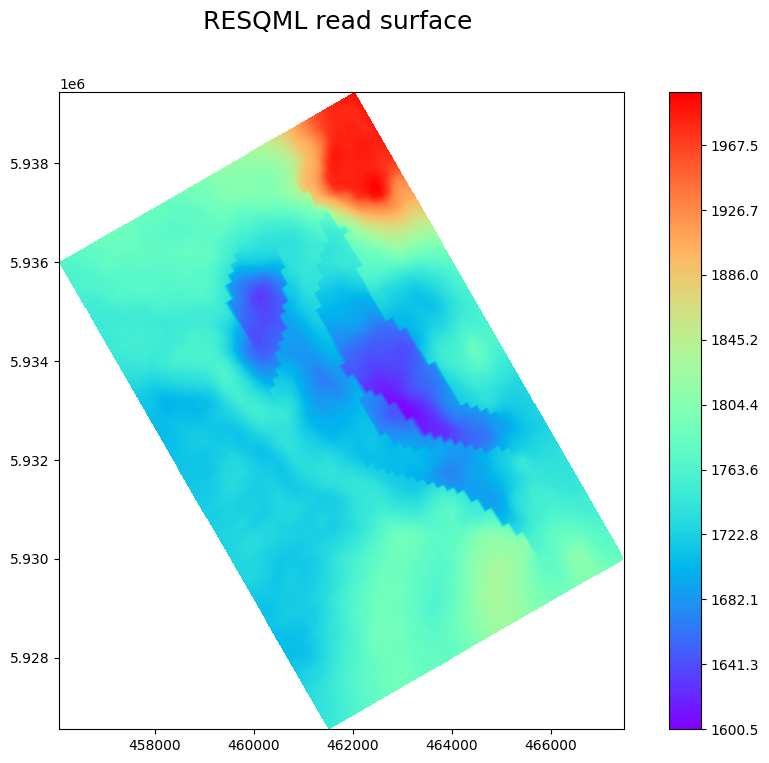

In [ ]:
read_crs_uuid = read_model.uuid(obj_type="obj_LocalDepth3dCrs")
read_crs = Crs(read_model, uuid=read_crs_uuid)

ncol = read_mesh.nj
nrow = read_mesh.ni
xinc = read_mesh.regular_dxyz_dij[0, 0]
yinc = read_mesh.regular_dxyz_dij[1, 1]
xori = read_crs.x_offset
yori = read_crs.y_offset
yflip = 1 if read_crs.z_inc_down else -1
rotation = read_crs.rotation
values = read_mesh.full_array_ref()[:, :, 2]

undef_value = ast.literal_eval(read_mesh.extra_metadata['data'])['spec']['undef']

masked_array = np.ma.masked_values(values, undef_value)

read_surf = xtgeo.RegularSurface(ncol=ncol, nrow=nrow, xinc=xinc, yinc=yinc, xori=xori, yori=yori, yflip=yflip, rotation=rotation, values=masked_array)
read_surf.quickplot(title="RESQML read surface")

In [ ]:
surf.quickplot(title="Surface directly from fmu")

NameError: name 'surf' is not defined

Check xtgeo equality

In [ ]:
(surf.values - read_surf.values).sum()

0.0

In [ ]:
(surf - read_surf).values.data[206, 206]

-0.0066638703908665775

In [ ]:
surfaces_are_equal = True
for i in range(0, ni):
    for j in range(0, nj):
        if surf.values.mask[j,i] or surf.values.data[j,i] == read_surf.values.data[j,i]:
            continue
        surfaces_are_equal = False
        print(surf.values.data[j,i])
        print(read_surf.values.data[j,i])

if surfaces_are_equal:
    print("Surfaces are equal!")
else:
    print("Surfaces are not equal!")

Surfaces are equal!
